In [1]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re
import fasttext

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm
tqdm.pandas()

In [2]:
# 試験ID生成
trial_prefix = 'nb018'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb017
nb017_20210602_001824


In [3]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [5]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [6]:
# read_data
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [7]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [9]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [11]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## 前処理_品詞変換

In [1]:
# テキスト情報を品詞に変換
def get_pos_tag(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return pos_tag

def get_pos_tag_to_text(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return " ".join(pos_tag)

## テキスト特徴_学習済みモデル（gemsim経由）

In [56]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1

class GensimPreTrainedBlock(BaseBlock):
    """
    文書をgemsim経由で学習済みモデルのベクトル表現へ変換するblock
    モデルは別途入手し、インスタンス作成時に指定する。
    モデル名は手動で入力する想定（デフォルトではgensim_pretrained で入る）
    """
    def __init__(self,
                 column: str,
                 model:KeyedVectors,
                 model_name='gensim_pretrained'):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model = model
        self.model_name = model_name

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
    
    # 文書ベクトルの取得
    def get_sentence_vector(self, model:KeyedVectors, x: str):
        ndim = model.vector_size
        embeddings = [
            model[word]
            if word in model
            else np.zeros(ndim)
            for word in x.split()
        ]

        if len(embeddings) == 0:
            return np.zeros(ndim, dtype=np.float32)
        else:
            return np.mean(embeddings, axis=0)

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: self.get_sentence_vector(self.model, x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'{self.model_name}_{self.column}_')

## テキスト特徴_fasttest

In [57]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1
class FasttextBlock(BaseBlock):
    """文書をfasttextのテキスト表現へ変換する block"""
    def __init__(self, column: str, ft_model:fasttext.FastText._FastText):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.ft_model = ft_model

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: ft_model.get_sentence_vector(x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'fasttext_{self.column}_')

## テキスト特徴_統計量

In [58]:
class TextDescriptionBlock(BaseBlock):
    """テキストに関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None, n_components=50):
        self.text = self.preprocess(input_df)
        self.counters = self.text.map(get_counter)
        return self.transform(input_df)

    def transform(self, input_df):
        _length = input_df[self.column].fillna('').map(lambda x: len(x) if x!='' else np.nan)
        _wrd_cnt = self.counters.map(lambda x: sum(x.values()))
        _wrd_nuniq = self.counters.map(lambda x: len(x))
        _wrd_mean = self.counters.map(lambda x: np.mean(list(x.values())))
        _wrd_max = self.counters.map(lambda x: np.max(list(x.values())))
        
        word_length = self.counters.map(lambda x: np.array([len(i) for i in x.keys()]))
        word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
        _word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]
        _word_length_desc_df = _word_length_desc_df.add_prefix('word_length_')
        
        out_df = pd.concat([_length, _wrd_cnt, _wrd_nuniq, _wrd_mean, _wrd_max], axis=1)
        out_df.columns = ['text_length', 'word_count', 'word_nunique', 'word_appearance_mean', 'word_appearance_max']
        out_df = pd.concat([out_df, _word_length_desc_df], axis=1)
        return out_df.add_suffix(f'_{self.column}')

## テキスト特徴_CountVectorizer

In [59]:
class CountVectorizerBlock(BaseBlock):
    """CountVectorizer x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', CountVectorizer(ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'countvect_{self.column}_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_TF-IDF

In [60]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000, ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'tfidf_{self.column}_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_W2V(データセットから学習)

In [61]:
# https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

class W2VTrainBlock(BaseBlock):
    """Word2Vecを学習し、文書のベクトル表現を得るブロック。
       学習済みモデルを使うパターンは、別に作成するものとする。"""
    def __init__(self, 
                 column: str, 
                 model_size=50, 
                 min_count=1, 
                 window=5,
                 n_iter=100
                 ):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model_size=model_size
        self.min_count=min_count
        self.window=window
        self.n_iter=n_iter

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """Word2Vecを学習するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])
        self.w2v_model = word2vec.Word2Vec(word_lists.values.tolist(),
                                      vector_size=self.model_size,
                                      min_count=self.min_count,
                                      window=self.window,
                                      seed=SEED,
                                      workers=1,
                                      hashfxn=hashfxn,
                                      epochs=self.n_iter)

        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = word_lists.progress_apply(
            lambda x: np.mean([self.w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"w2v_{self.column}_w{self.window}_{i}"
                                                   for i in range(self.model_size)])
        
        return sentence_vector_df


# make_feat

In [150]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = pd.concat([train_base[['id', 'excerpt']], test_base[['id', 'excerpt']]], axis='rows')

In [ ]:
# モデル入手
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    fast_path = '../input/fasttext-pretrained-crawl-vector-en-bin/cc.en.300.bin'
    gen_glv_wiki_path = '../input/stanfords-glove-pretrained-word-vectors/glove.6B.300d.txt'
    gen_glv_twi_path = '../input/glovetwitter27b-in-gensim-kv-format/glove.twitter.27B.200d.kv'
    gen_ggl_path = '../input/gensim-google-data/GoogleNews-vectors-negative300.bin'

    ft_model = fasttext.load_model(fast_path)
    gen_glv_wiki_model = KeyedVectors.load_word2vec_format(gen_glv_wiki_path, binary=False)
    #gen_glv_twi_model = KeyedVectors.load(gen_glv_twi_path)
    #gen_ggl_model = KeyedVectors.load_word2vec_format(gen_ggl_path, binary=True)
    
else: # ローカルまたは自前のクラウド環境を想定
    fast_path = '../97_pre_trained/cc.en.300.bin'
    gen_glv_wiki_path = '~/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300'
    gen_glv_twi_path = '~/gensim-data/glove-twitter-200/glove-twitter-200.gz'
    gen_ggl_path = '~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'

    ft_model = fasttext.load_model('../97_pre_trained/cc.en.300.bin')
    gen_glv_wiki_model = KeyedVectors.load_word2vec_format(gen_glv_wiki_path, binary=False)
    #gen_glv_twi_model = KeyedVectors.load_word2vec_format(gen_glv_twi_path, binary=False)
    #gen_ggl_model = KeyedVectors.load_word2vec_format(gen_ggl_path, binary=True)

In [151]:
# テキスト前処理
# 品詞変換カラムの作成
train_base['excerpt_pos'] = train_base['excerpt'].progress_map(get_pos_tag_to_text)
test_base['excerpt_pos'] = test_base['excerpt'].progress_map(get_pos_tag_to_text)
whole_df['excerpt_pos'] = whole_df['excerpt'].progress_map(get_pos_tag_to_text)

100%|██████████| 2841/2841 [00:18<00:00, 151.48it/s]


In [152]:
# block初期化
text_desc = TextDescriptionBlock('excerpt')
fast = FasttextBlock('excerpt', ft_model)
gen_glv_wiki = GensimPreTrainedBlock('excerpt', gen_glv_wiki_model, 'glove_wiki_giga300')

cntvec_bi = CountVectorizerBlock('excerpt', ngram_range=(2,2))

tfidf_uni = TfidfBlock('excerpt', ngram_range=(1,1))
tfidf_bi = TfidfBlock('excerpt', ngram_range=(2,2))
tfidf_uni_bi = TfidfBlock('excerpt', ngram_range=(1,2))

w2v_w3 = W2VTrainBlock('excerpt', window=3)
w2v_w10 = W2VTrainBlock('excerpt', window=10)
w2v_w100 = W2VTrainBlock('excerpt', window=100)

# 品詞変換
cntvec_pos_1_1 = CountVectorizerBlock('excerpt_pos', ngram_range=(1,1), n_components=10)
cntvec_pos_1_3 = CountVectorizerBlock('excerpt_pos', ngram_range=(1,3), n_components=10)
cntvec_pos_2_2 = CountVectorizerBlock('excerpt_pos', ngram_range=(2,2), n_components=10)
cntvec_pos_5_5 = CountVectorizerBlock('excerpt_pos', ngram_range=(5,5), n_components=10)

tfidf_pos_1_1 = TfidfBlock('excerpt_pos', ngram_range=(1,1), n_components=10)
tfidf_pos_1_3 = TfidfBlock('excerpt_pos', ngram_range=(1,3), n_components=10)
tfidf_pos_2_2 = TfidfBlock('excerpt_pos', ngram_range=(2,2), n_components=10)
tfidf_pos_5_5 = TfidfBlock('excerpt_pos', ngram_range=(5,5), n_components=10)

w2v_pos_w3 = W2VTrainBlock('excerpt_pos', window=3)
w2v_pos_w10 = W2VTrainBlock('excerpt_pos', window=10)
w2v_pos_w100 = W2VTrainBlock('excerpt_pos', window=100)

In [153]:
# fit & trainの特徴作成
# 単体で完結するもの
train_feat = pd.concat([train_feat, text_desc.fit(train_base)], axis='columns')
train_feat = pd.concat([train_feat, fast.fit(train_base)], axis='columns')
train_feat = pd.concat([train_feat, gen_glv_wiki.fit(train_base)], axis='columns')

# 対象dfとは別に、特徴作成用dfを指定するもの
train_feat = pd.concat([train_feat, cntvec_bi.fit(train_base, whole_df)], axis='columns')

train_feat = pd.concat([train_feat, tfidf_uni.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_bi.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_uni_bi.fit(train_base, whole_df)], axis='columns')

train_feat = pd.concat([train_feat, w2v_w3.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_w10.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_w100.fit(train_base, whole_df)], axis='columns')

# 品詞変換
train_feat = pd.concat([train_feat, cntvec_pos_1_1.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, cntvec_pos_1_3.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, cntvec_pos_2_2.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, cntvec_pos_5_5.fit(train_base, whole_df)], axis='columns')

train_feat = pd.concat([train_feat, tfidf_pos_1_1.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_pos_1_3.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_pos_2_2.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_pos_5_5.fit(train_base, whole_df)], axis='columns')

train_feat = pd.concat([train_feat, w2v_pos_w3.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_pos_w10.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_pos_w100.fit(train_base, whole_df)], axis='columns')

100%|██████████| 2834/2834 [00:00<00:00, 3624.62it/s]


In [154]:
# testの特徴作成
# 単体で完結するもの
test_feat = pd.concat([test_feat, text_desc.fit(test_base)], axis='columns')
test_feat = pd.concat([test_feat, fast.fit(test_base)], axis='columns')
test_feat = pd.concat([test_feat, gen_glv_wiki.fit(test_base)], axis='columns')

# 対象dfとは別に、特徴作成用dfを指定するもの
test_feat = pd.concat([test_feat, cntvec_bi.transform(test_base)], axis='columns')

test_feat = pd.concat([test_feat, tfidf_uni.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_bi.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_uni_bi.transform(test_base)], axis='columns')

test_feat = pd.concat([test_feat, w2v_w3.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_w10.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_w100.transform(test_base)], axis='columns')

# 品詞変換
test_feat = pd.concat([test_feat, cntvec_pos_1_1.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, cntvec_pos_1_3.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, cntvec_pos_2_2.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, cntvec_pos_5_5.transform(test_base)], axis='columns')

test_feat = pd.concat([test_feat, tfidf_pos_1_1.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_pos_1_3.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_pos_2_2.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_pos_5_5.transform(test_base)], axis='columns')

test_feat = pd.concat([test_feat, w2v_pos_w3.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_pos_w10.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_pos_w100.transform(test_base)], axis='columns')

100%|██████████| 7/7 [00:00<00:00, 1039.00it/s]


In [155]:
print(train_feat.shape)
train_feat.head()

(2834, 230)


,countvect_excerpt_pos_1_1_0,countvect_excerpt_pos_1_1_1,countvect_excerpt_pos_1_1_2,countvect_excerpt_pos_1_1_3,countvect_excerpt_pos_1_1_4,countvect_excerpt_pos_1_1_5,countvect_excerpt_pos_1_1_6,countvect_excerpt_pos_1_1_7,countvect_excerpt_pos_1_1_8,countvect_excerpt_pos_1_1_9,...,w2v_excerpt_pos_w100_40,w2v_excerpt_pos_w100_41,w2v_excerpt_pos_w100_42,w2v_excerpt_pos_w100_43,w2v_excerpt_pos_w100_44,w2v_excerpt_pos_w100_45,w2v_excerpt_pos_w100_46,w2v_excerpt_pos_w100_47,w2v_excerpt_pos_w100_48,w2v_excerpt_pos_w100_49
0,48.739783,-3.937335,2.369246,-10.957048,-10.230055,2.801940,-0.818924,0.240446,1.744416,0.224264,...,0.275937,-0.430648,0.059489,0.217508,-0.073596,-0.041004,-0.196247,-0.068950,0.118895,-0.000632
1,43.714710,14.382321,-4.176727,10.853410,6.206331,-4.134689,-0.605049,-2.218185,-5.304327,-0.523855,...,-0.207644,0.288936,0.203570,-0.698292,0.158151,-0.029395,-0.083748,0.421583,-0.366129,0.197612
2,39.525590,16.963885,8.570037,8.143756,3.685251,-3.868177,3.920201,1.862043,8.618361,0.378749,...,-0.180037,0.283357,0.027148,-0.285875,0.012891,0.253934,-0.430929,0.674142,-0.200735,0.077933
3,52.439362,-5.812352,-7.452593,-4.918789,0.481655,-9.790688,-6.140089,-0.767941,-0.959021,6.575585,...,0.339480,-0.333269,0.029030,-0.067740,0.050474,-0.071646,-0.074055,-0.072673,-0.120618,-0.080596
4,39.761542,7.093237,29.982762,-2.744591,0.854638,8.319641,6.880296,-3.744479,-5.363290,9.942027,...,-0.276552,-0.222123,-0.244493,0.487143,-0.340906,0.660176,-0.709704,0.879205,0.053497,0.000881


In [156]:
print(test_feat.shape)
test_feat.head()

(7, 230)


,countvect_excerpt_pos_1_1_0,countvect_excerpt_pos_1_1_1,countvect_excerpt_pos_1_1_2,countvect_excerpt_pos_1_1_3,countvect_excerpt_pos_1_1_4,countvect_excerpt_pos_1_1_5,countvect_excerpt_pos_1_1_6,countvect_excerpt_pos_1_1_7,countvect_excerpt_pos_1_1_8,countvect_excerpt_pos_1_1_9,...,w2v_excerpt_pos_w100_40,w2v_excerpt_pos_w100_41,w2v_excerpt_pos_w100_42,w2v_excerpt_pos_w100_43,w2v_excerpt_pos_w100_44,w2v_excerpt_pos_w100_45,w2v_excerpt_pos_w100_46,w2v_excerpt_pos_w100_47,w2v_excerpt_pos_w100_48,w2v_excerpt_pos_w100_49
0,43.141667,-0.979970,-6.109132,-3.073518,5.093331,-0.226482,0.975781,-1.579390,-7.148359,0.766977,...,0.109142,-0.013594,-0.002405,-0.397699,-0.035542,-0.147773,0.006578,0.066378,-0.358843,-0.004868
1,44.377966,14.648783,4.257791,0.467252,-2.928314,3.923037,3.810062,6.343726,-2.399230,1.313680,...,-0.116005,0.179724,0.081935,-0.310149,-0.100806,-0.106666,-0.201510,0.495227,-0.047535,0.376779
2,44.799596,15.926662,6.937119,1.906394,2.747230,-4.213229,1.961961,-3.487495,3.743805,4.071466,...,-0.015422,0.143430,0.018484,-0.176709,-0.035566,0.230144,-0.447556,0.674266,-0.166361,0.220465
3,50.594604,-18.374007,0.287152,-0.119355,4.092776,-6.180110,-4.657810,-0.717934,4.807711,-5.351442,...,0.128906,-0.270511,0.036288,0.095130,0.095170,0.200285,0.047941,-0.447131,-0.229022,-0.829945
4,37.801438,-3.221908,10.209879,6.759690,0.739761,-2.963950,-1.974289,2.064047,2.908813,-0.916414,...,-0.080976,-0.083480,0.122116,0.052915,0.073435,0.350934,-0.070154,0.044708,-0.180036,-0.434668


In [157]:
print(train_feat.shape)
print(test_feat.shape)

(2834, 230)
(7, 230)


# train & predict

In [158]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [159]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [160]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [161]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [162]:
oof_preds = np.zeros(len(train_feat))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train_target.iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train_target.iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58650
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 230
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.440093	valid's rmse: 0.824316
Early stopping, best iteration is:
[44]	training's rmse: 0.471592	valid's rmse: 0.819617

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58650
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 230
[LightGBM] [Info] Start training from score -0.946950
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.4

In [163]:
sample['target'] = test_preds

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    sample.to_csv('submission.csv',index=False)
else:
    sample.to_csv(OUTPUT_DIR/'submission.csv',index=False)

In [164]:
print(sample.shape)
sample.head()

(7, 2)


,id,target
0,c0f722661,-0.790568
1,f0953f0a5,-0.377208
2,0df072751,-0.795109
3,04caf4e0c,-1.608097
4,0e63f8bea,-1.036755


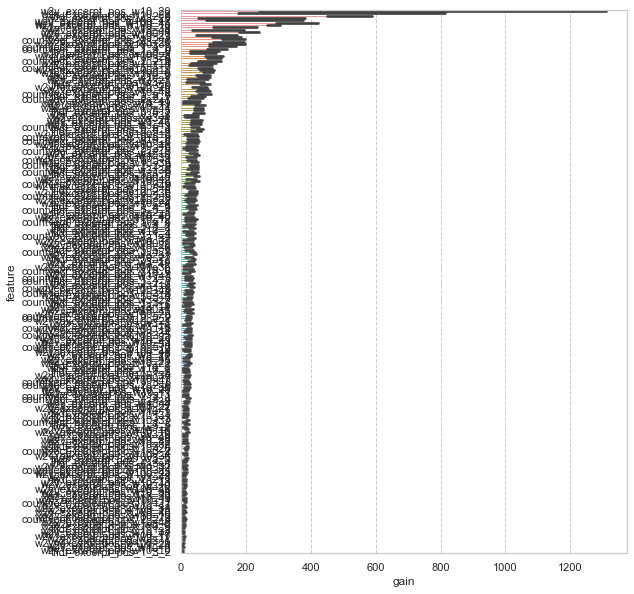

In [165]:
# importance(kaggle環境では描画しない)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    plt.figure(figsize=(8, 10))
    sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

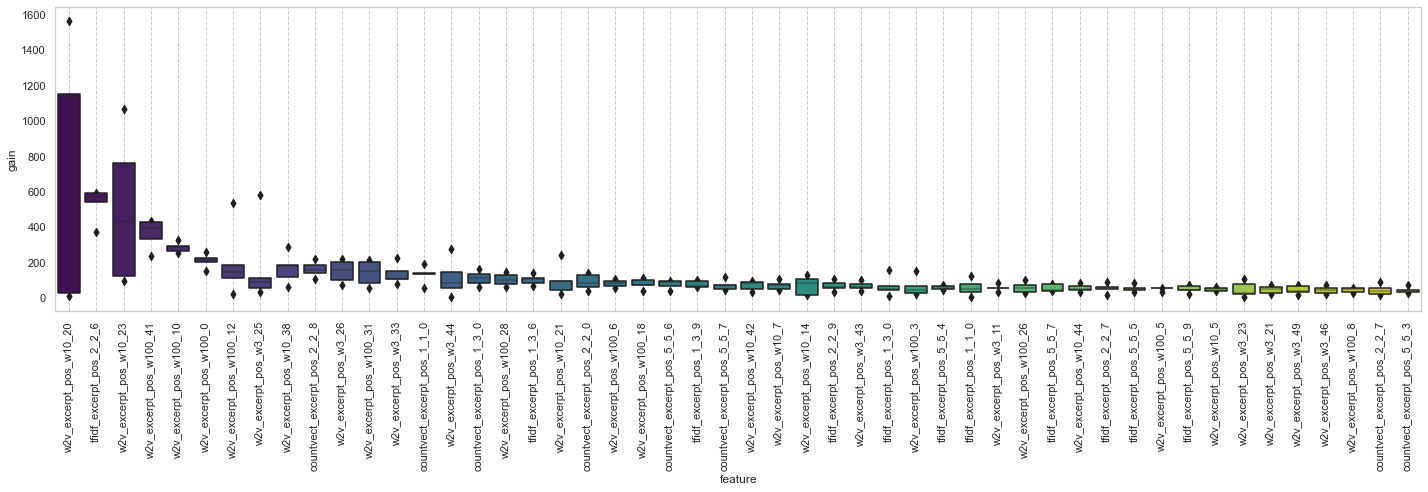

In [166]:
# importance_boxen(kaggle環境では描画しない)
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    order = importances.groupby('feature')\
        .sum()[['gain']]\
        .sort_values('gain', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [167]:
# SHAP(kaggle環境では描画しない)
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap_values = []
    for model_ in models:
        explainer = shap.TreeExplainer(model_)
        shap_values.append(explainer.shap_values(train_feat))

    shap_mean = np.mean(shap_values, axis=0)

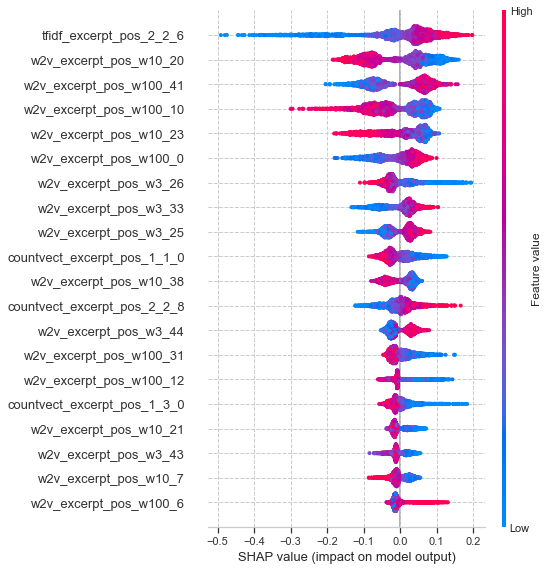

In [168]:
# SHAP_summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap.summary_plot(shap_mean, train_feat, show=False)
    plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

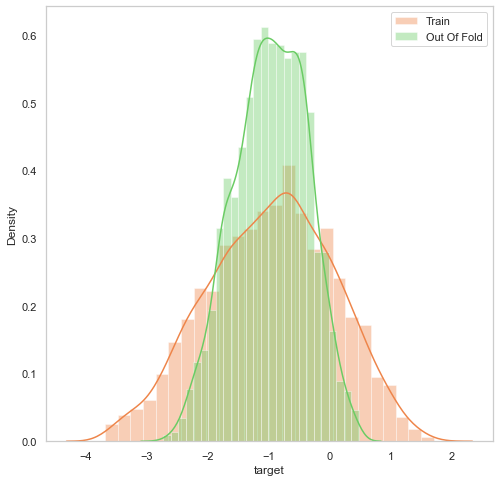

In [169]:
# 分布(train_vs_oof)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_target, label='Train', ax=ax, color='C1')
    sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
    ax.legend()
    ax.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))